# ดาวน์โหลดชุดข้อมูล

ชุดข้อมูลที่ใช้ในตัวอย่างครั้งนี้คือ ชุดข้อมูลภาพสำหรับการตรวจสอบคุณภาพของผลิตภัณฑ์ที่ถูกหล่อ (casting product image data for quality inspection dataset, https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product?resource=download).



In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"schwanabc","key":"25205411e6ed47f72197114be066cf42"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product
!unzip -q real-life-industrial-dataset-of-casting-product.zip

100% 100M/100M [00:03<00:00, 39.1MB/s] 
100% 100M/100M [00:03<00:00, 28.1MB/s]


ข้อมูลในชุดข้อมูลนี้มีถูกเก็บอยู่ใน folder def_front และ ok_front ซึ่งเก็บผลิตภัณฑ์ที่มีตำหนิและผลิตภัณฑ์ปกติที่ผ่านมาตรฐานตามลำดับ

```
casting_data_512x512
|--casting_data_512x512
      |--def_front
      |  |--cast_def_0_10.jpeg
      |  |--.. 
      |--ok_front
         |--cast_ok_0_10.jpeg
         |--..


## แสดงตัวอย่างภาพในชุดข้อมูล

สามารถนำข้อมูลจาก file ภาพมาใส่ในตัวแปรได้ด้วยคำสั้ง `cv2.imread(img_path)` ซึ่งเป็นคำสั่งของ library opencv

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
train_file_list_ok = glob.glob('./casting_512x512/casting_512x512/ok_front/*.jpeg')
train_file_list_def = glob.glob('./casting_512x512/casting_512x512/def_front/*.jpeg')

#sample five images fro each class
example_ok = np.random.choice(train_file_list_ok, 5, replace = False)
example_def = np.random.choice(train_file_list_def, 5, replace = False)

แสดงตัวอย่างคำสั้่งการ load รูป

./casting_512x512/casting_512x512/ok_front/cast_ok_0_2046.jpeg (512, 512, 3)


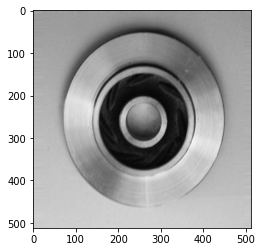

In [ ]:
img = cv2.imread(example_ok[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert bgr to rgb image
print(example_ok[0], img.shape)
plt.imshow(img)
plt.show()

แสดง 5 ตัวอย่างจาก class `ok_front` กับ `def_front`

ok product


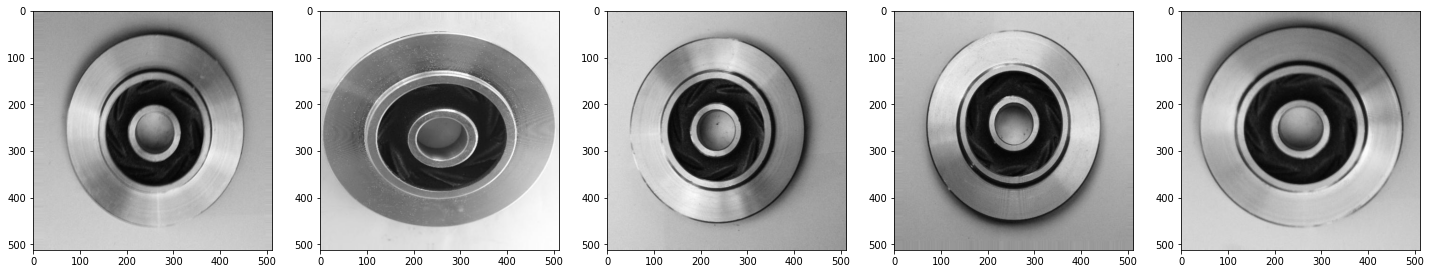

In [ ]:
plt.figure(figsize = (30, 60))
print('ok product')
for i in range(len(example_ok)):
  plt.subplot(1, 6, i+1)
  img = cv2.imread(example_ok[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert bgr to rgb image
  plt.imshow(img)
plt.show()

default product


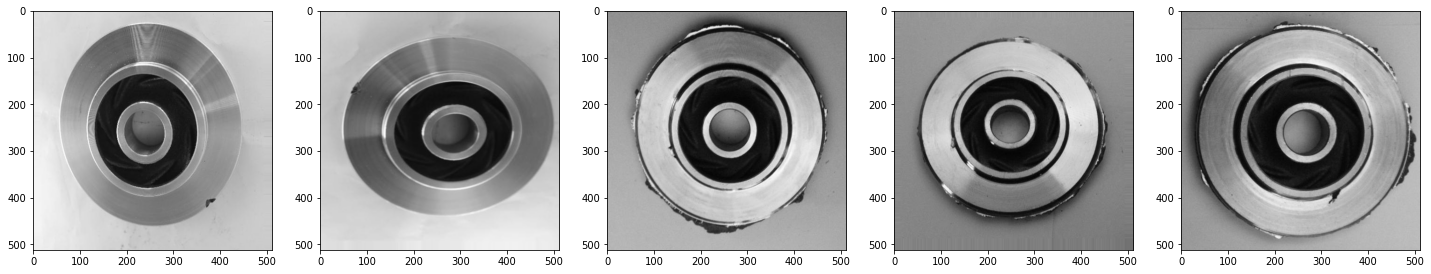

In [ ]:
plt.figure(figsize = (30, 60))
print('default product')
for i in range(len(example_def)):
  plt.subplot(1, 6, i+1)
  img = cv2.imread(example_def[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert bgr to rgb image
  plt.imshow(img)
plt.show()

## ปรับเปลียนข้อมูลให้อยู่ในสภาพที่ฝึกสอน model ได้

ขนาดภาพถูกลดจาก 512 x 512 เป็น 224 x 224 เพื่อความรวดเร็วในการฝึกสอน model

ข้อมูลภาพที่ถูกปรับขนาดจะอยู่ใน array ที่มีขนาด `(n_data, height, width, 3)`

In [ ]:
class_dict = { 'ok_front' : 0, 'def_front' : 1}
X_train = []
Y_train = []
train_file_list = glob.glob('./casting_512x512/casting_512x512/*/*.jpeg')
for img_path in train_file_list:
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_LINEAR ) #bilinear interpolation
  class_name = img_path.split('/')[-2]
  X_train.append(img)
  Y_train.append(class_dict[class_name])
X_train = np.array(X_train, dtype = np.float32)
Y_train = np.array(Y_train, dtype = np.float32)
print("Input shape :", X_train.shape, "Output shape :", Y_train.shape)

Input shape : (1300, 224, 224, 3) Output shape : (1300,)


สำหรับการทดสอบประสิทธิภาพ model นั้นข้อมูลจะถูกแบ่งเป็น train/val/test โดย test นั้นมีขนาดเป็น 30% ของชุดข้อมูล

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)
print("Training input shape :", X_train.shape, "Training output shape :", Y_train.shape)
print("Validation input shape :", X_val.shape, "Validation output shape :", Y_val.shape)
print("Test input shape :", X_test.shape, "Validation output shape :", Y_test.shape)

Training input shape : (728, 224, 224, 3) Training output shape : (728,)
Validation input shape : (182, 224, 224, 3) Validation output shape : (182,)
Test input shape : (390, 224, 224, 3) Validation output shape : (390,)


## 1. Image classification from scratch

ในส่วนนี้แสดงตัวอย่างการสร้าง CNN ที่มีขนาดหลาย layer ตามที่เขียนใน method `get_simple_model` ทั้งนี้ CNN จะมีทั้งหมด 4 stage โดย stage ที่ $i$ จะมี filter ทั้งหมด $2^{i-1}(32)$ filter 

ปกติแล้วหลักจากทำ operation convolution แล้วจะต้องทำการ batch normalization และใส่ non-linear activation function ตามมา โดยทั้งสามขั้นตอนนี้สามารถถูกมัดรวมกันได้ตามคำสั่งใน method `convolution_block`

In [ ]:
import tensorflow as tf

def convolution_block(input_layer, num_features, kernel_size = (3,3)):
  '''
  A standard convolution block in Conv-BN-Relu format.
  Input: 
    input_layer : the input layer
    num_features : number of convolutilon filter  
    kernel_size : kernel side of the convolution layer  
  Output:
    x : the output layer after getting fed by the three layers 
  '''
  x = tf.keras.layers.Conv2D(filters = num_features, kernel_size = kernel_size, padding = 'same')(input_layer)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  return x

def get_simple_model(input_shape = (256, 256, 3)):
  input_layer = tf.keras.layers.Input(shape = input_shape)
  stage_1 = convolution_block(input_layer, 32)
  stage_1_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(stage_1)

  stage_2 = convolution_block(stage_1_pool, 64)
  stage_2_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(stage_2)

  stage_3 = convolution_block(stage_2_pool, 128)
  stage_3_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(stage_3)

  stage_4 = convolution_block(stage_2_pool, 256)
  stage_4_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(stage_4)

  pooler = tf.keras.layers.GlobalAveragePooling2D()(stage_4_pool)
  out = tf.keras.layers.Dense(1)(pooler)
  outputs = tf.keras.layers.Activation('sigmoid')(out)

  model = tf.keras.models.Model(inputs = input_layer, outputs = outputs)
  return model


ประกาศตัวแปร model และ component ที่สำคัญ

 `optimizer` : Optimization algorithm ที่ต้องการใช้ในการ optimize model

 `loss` : Objective function ของปัญหาที่ต้องการจะแก้

 `metric`: มาตรวัดที่ต้องการสังเกต ทั้งนี้เราสามารถสังเกตหลายมาตรวัดพร้อมกันได้

`BATCH_SIZE`: ขนาด batch size สำหรับแต่ละ iteration

In [ ]:
model = get_simple_model(input_shape = (224, 224, 3))
model.compile(optimizer= tf.keras.optimizers.Adam(5e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
BATCH_SIZE = 32

สามารถดูภาพรวมว่า model นั้นประกอบกันเป็นอย่างไรได้ด้วยคคำสั่ง `model.summary()`

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      1849

ในส่วนนี้เป็นการ generator และ callback สำหรับการฝึกสอน model

generator นั้นทำงานคล้าย function แต่ใช้คำสั้ง yield แทน return ในการคืนค่า generator นั้นมีข้อดีคือสามารถทำให้ function ทำงานต่อได้ถึงแม้คืนค่ามาแล้ว ในส่วน `ImageDataGenerator` นั้นจะเป็น generator โดยเฉพาะสำหรับการเตรียมข้อมูลภาพ สามารถอ่านเพิ่มได้ที่ https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

callback เป็น function ที่ model เรียกใช้งานเมื่อ model train เสร็จครบ epoch แล้ว ในตัวอย่างนี้มีการใช้ `ModelCheckpoint` เพื่อ save model ที่มี validation loss ที่ต่ำที่สุด

In [ ]:
# genertor is similar to function but use yield instead
def example_generator():
  i =0 
  while(True):
    yield (i + 1) ** 2
    i+=1

example_gen = example_generator()
print("first yield", next(example_gen))
print("second yield", next(example_gen))
print("third yield", next(example_gen))

first yield 1
second yield 4
third yield 9


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'model_custom.h5',
    monitor = "val_loss")
]

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
         validation_data=val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE),
         steps_per_epoch = int(len(X_train) / BATCH_SIZE), epochs=20, callbacks = callbacks, shuffle = True)

Epoch 1/20
12/12 [==============================] - 2s 132ms/step - loss: 0.5210 - accuracy: 0.7440 - val_loss: 7.5719 - val_accuracy: 0.4412
Epoch 2/20
12/12 [==============================] - 1s 95ms/step - loss: 0.4919 - accuracy: 0.7707 - val_loss: 5.3898 - val_accuracy: 0.4412
Epoch 3/20
12/12 [==============================] - 1s 95ms/step - loss: 0.4481 - accuracy: 0.7867 - val_loss: 3.6084 - val_accuracy: 0.4412
Epoch 4/20
12/12 [==============================] - 1s 96ms/step - loss: 0.4492 - accuracy: 0.8027 - val_loss: 3.2466 - val_accuracy: 0.4412
Epoch 5/20
12/12 [==============================] - 1s 96ms/step - loss: 0.4504 - accuracy: 0.7867 - val_loss: 3.9385 - val_accuracy: 0.4412
Epoch 6/20
12/12 [==============================] - 1s 97ms/step - loss: 0.4555 - accuracy: 0.7973 - val_loss: 3.1829 - val_accuracy: 0.4412
Epoch 7/20
12/12 [==============================] - 1s 95ms/step - loss: 0.4313 - accuracy: 0.8133 - val_loss: 2.3027 - val_accuracy: 0.4412
Epoch 8/20
1

เมื่อเราดูตัวแปร `history` จะสามารถดู log ซึ่งเกิดขึ้นระหว่างการ train ได้จะเห็นได้ว่าเมื่อ train ไปเรื่อยๆแม้ training loss จะลดลงอย่างต่อเนื่อง แต่ validation accuracy ไม่ได้ไปในทิศเดียวกันตลอดซึ่งอาจตีความได้ว่า model นั้น overfit กับ training data ไปแล้ว

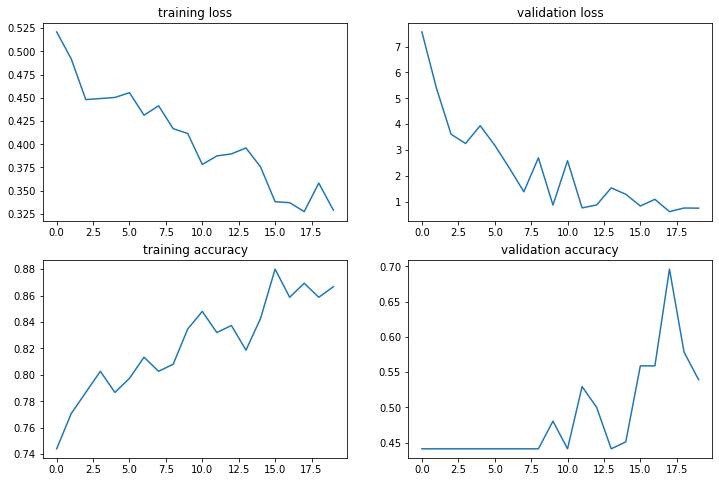

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.title('training loss')
plt.subplot(2,2,2)
plt.plot(history.history['val_loss'])
plt.title('validation loss')
plt.subplot(2,2,3)
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.show()

load model ที่ดีที่สุดและทำนายผลบน test set

In [ ]:
model.load_weights('model_custom.h5') # load the best model
Y_test_pred = model.predict(X_test).reshape(-1)

7/7 [==============================] - 0s 33ms/step


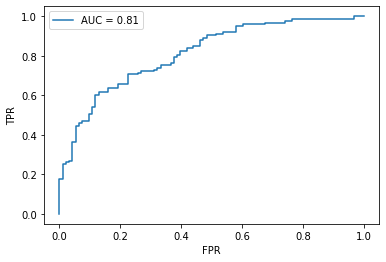

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, Y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 3. Transfer learning from ImageNet 
ตรงกันข้ามกับ section 2 ที่เราได้เขียน model จากเริ่มต้นทั้งหมด ใน section นี้เราจะใช้ model ที่ train มาจากฐานข้อมูล Imagenet ซึ่งมีภาพมากกว่าหนึ่งล้านภาพที่มีความหลากหลายสูง

In [ ]:
import tensorflow as tf

def get_classification_model(input_shape = (256, 256, 3)):
    from tensorflow.keras.applications.resnet50 import ResNet50
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top = False)
    pooler = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
    out = tf.keras.layers.Dense(1)(pooler)
    outputs = tf.keras.layers.Activation('sigmoid')(out)
    model = tf.keras.models.Model(inputs = backbone.input, outputs = outputs)
    return model


In [ ]:
model = get_classification_model(input_shape = (224, 224, 3))
model.compile(optimizer= tf.keras.optimizers.Adam(5e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'model_pretrained.h5',
    monitor = "val_loss")
]

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
         validation_data=val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE),
         steps_per_epoch = int(len(X_train) / BATCH_SIZE), epochs=20, callbacks = callbacks, shuffle = True)

Epoch 1/20
12/12 [==============================] - 16s 615ms/step - loss: 0.4505 - accuracy: 0.8533 - val_loss: 0.4869 - val_accuracy: 0.7549
Epoch 2/20
12/12 [==============================] - 5s 454ms/step - loss: 0.0971 - accuracy: 0.9627 - val_loss: 0.6435 - val_accuracy: 0.8824
Epoch 3/20
12/12 [==============================] - 5s 460ms/step - loss: 0.0804 - accuracy: 0.9787 - val_loss: 57.2793 - val_accuracy: 0.5588
Epoch 4/20
12/12 [==============================] - 5s 456ms/step - loss: 0.0787 - accuracy: 0.9760 - val_loss: 161.8850 - val_accuracy: 0.5588
Epoch 5/20
12/12 [==============================] - 5s 452ms/step - loss: 0.0792 - accuracy: 0.9707 - val_loss: 147.8616 - val_accuracy: 0.5588
Epoch 6/20
12/12 [==============================] - 5s 455ms/step - loss: 0.0769 - accuracy: 0.9707 - val_loss: 64.6340 - val_accuracy: 0.5588
Epoch 7/20
12/12 [==============================] - 5s 454ms/step - loss: 0.0750 - accuracy: 0.9867 - val_loss: 158.7074 - val_accuracy: 0.55

จะเห็นได้ว่า model ที่ pretrain มานั้นถึง loss สูงมากในช่วงแรกแต่ก็สามารถลดระดับได้อย่างรวดเร็วทำให้ประสิทธิภาพดีกว่า model ที่เริ่มจาไม่มีอะไรเลย แต่ปัญหาด้านความเสถียรของ model ยังคงอยู่เนื่องจาก model overfit ได้ง่ายเนื่องจากปริมาณ data ที่มีน้อย

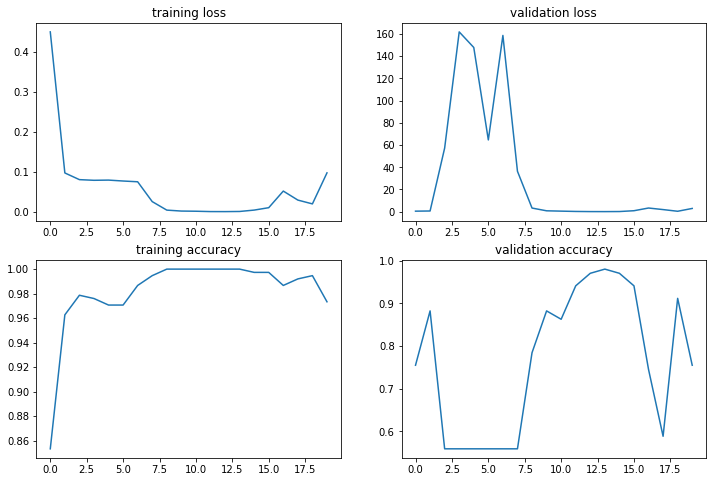

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.title('training loss')
plt.subplot(2,2,2)
plt.plot(history.history['val_loss'])
plt.title('validation loss')
plt.subplot(2,2,3)
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.show()

7/7 [==============================] - 2s 209ms/step


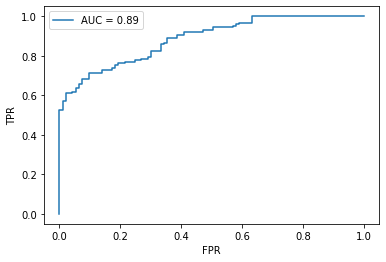

In [ ]:
model.load_weights('model_pretrained.h5') # load the best model
Y_test_pred = model.predict(X_test).reshape(-1)
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, Y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 4. Data augmentation

เพื่อแก้ปัญหาปริมาณข้อมูลที่มีน้อยเราจึงต้องหาวิธีการอะไรบางอย่างเพื่อเพิ่มความหลากหลายของข้อมูล โดยงานเกี่ยวกับภาพนั้นสามารถเพิ่มความหลากหลายของข้อมูลได้ด้วยการ augment ข้อมูล เช่น การเปลี่ยนความสว่าง การหมุนภาพ การเลื่อนภาพ เป็นต้น ทั้งนี้ใน `ImageDataGenerator` ก็ได้รองรับการทำงานตามที่กล่าวมาได้ด้วย

In [ ]:
model = get_classification_model(input_shape = (224, 224, 3))
model.compile(optimizer= tf.keras.optimizers.Adam(5e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = (0.8, 1.2)
    )

val_datagen = ImageDataGenerator()
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'model_pretrained_augmented.h5',
    monitor = "val_loss")
]

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
         validation_data=val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE),
         steps_per_epoch = int(len(X_train) / BATCH_SIZE), epochs=20, callbacks = callbacks, shuffle = True)

Epoch 1/20
22/22 [==============================] - 23s 549ms/step - loss: 0.4331 - accuracy: 0.8290 - val_loss: 101.9076 - val_accuracy: 0.6099
Epoch 2/20
22/22 [==============================] - 9s 406ms/step - loss: 0.1528 - accuracy: 0.9497 - val_loss: 319.1622 - val_accuracy: 0.6099
Epoch 3/20
22/22 [==============================] - 9s 407ms/step - loss: 0.1020 - accuracy: 0.9698 - val_loss: 165.3040 - val_accuracy: 0.6099
Epoch 4/20
22/22 [==============================] - 9s 408ms/step - loss: 0.0642 - accuracy: 0.9756 - val_loss: 50.4698 - val_accuracy: 0.6099
Epoch 5/20
22/22 [==============================] - 9s 406ms/step - loss: 0.0635 - accuracy: 0.9856 - val_loss: 27.1714 - val_accuracy: 0.6099
Epoch 6/20
22/22 [==============================] - 9s 408ms/step - loss: 0.0738 - accuracy: 0.9799 - val_loss: 17.9108 - val_accuracy: 0.6099
Epoch 7/20
22/22 [==============================] - 9s 410ms/step - loss: 0.0177 - accuracy: 0.9957 - val_loss: 1.3584 - val_accuracy: 0.8

จากผลลัพทธ์ด้านล่างจะเห็นได้ว่า model ที่ได้รับ input ที่ถูก augment มาความสามารถในการทำนายสูงกว่า model ที่ไม่มี แต่ทว่าปัญหาด้าความเสถียรยังคงอยู่ สังเกตได้จาก validation loss และ accuracy ปรับตัวอย่างรุนแรงหลัง epoch ที่ 10 นี่แสดงให้เห็นว่า learning rate คงที่ที่ใช้อยู่นั้นไม่เหมาะสมเมื่อ model ถูก train ไประยะหนึ่ง

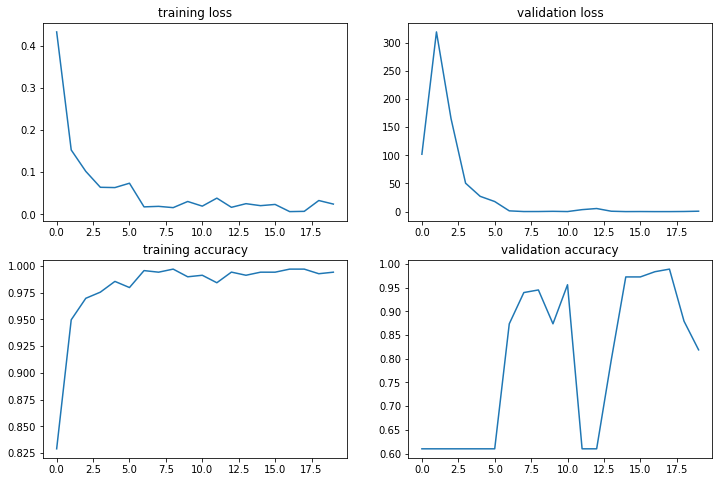

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.title('training loss')
plt.subplot(2,2,2)
plt.plot(history.history['val_loss'])
plt.title('validation loss')
plt.subplot(2,2,3)
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.show()

13/13 [==============================] - 2s 128ms/step


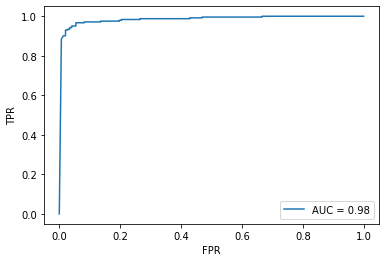

In [ ]:
model.load_weights('model_pretrained_augmented.h5') # load the best model
Y_test_pred = model.predict(X_test).reshape(-1)
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, Y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 4. Learning rate scheduling

การ schedule learning rate นั้นสามารถทำได้ง่ายโดยเพียงแค่ใส่ callback `LearningRateScheduler` เพิ่มโดย callback นี้รับ function เป็น input ซึ่ง function นี้จะคอยกำหนดว่าที่ epoch ต่างๆมีค่า learning rate เป็นเท่าไหร่

In [ ]:
model = get_classification_model(input_shape = (224, 224, 3))
model.compile(optimizer= tf.keras.optimizers.Adam(5e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def scheduler(epoch, lr):
  init_lr = 5e-4
  lr = init_lr
  if epoch < 8:
    return lr
  else:
    return lr * 0.1

datagen = ImageDataGenerator(
    # rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = (0.8, 1.2)
    )
val_datagen = ImageDataGenerator()
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'model_pretrained_augmented_scheduled.h5',
    monitor = "val_loss"), tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
         validation_data=val_datagen.flow(X_val, Y_val, batch_size=BATCH_SIZE),
         steps_per_epoch = int(len(X_train) / BATCH_SIZE), epochs=20, callbacks = callbacks, shuffle = True)

Epoch 1/20
22/22 [==============================] - 17s 454ms/step - loss: 0.3025 - accuracy: 0.8851 - val_loss: 9.8948 - val_accuracy: 0.6099 - lr: 5.0000e-04
Epoch 2/20
22/22 [==============================] - 9s 406ms/step - loss: 0.1318 - accuracy: 0.9555 - val_loss: 4972.0776 - val_accuracy: 0.6099 - lr: 5.0000e-04
Epoch 3/20
22/22 [==============================] - 9s 406ms/step - loss: 0.0963 - accuracy: 0.9655 - val_loss: 216.5630 - val_accuracy: 0.6099 - lr: 5.0000e-04
Epoch 4/20
22/22 [==============================] - 9s 412ms/step - loss: 0.0451 - accuracy: 0.9899 - val_loss: 7.9764 - val_accuracy: 0.6209 - lr: 5.0000e-04
Epoch 5/20
22/22 [==============================] - 9s 412ms/step - loss: 0.0194 - accuracy: 0.9929 - val_loss: 3.7630 - val_accuracy: 0.8407 - lr: 5.0000e-04
Epoch 6/20
22/22 [==============================] - 9s 410ms/step - loss: 0.0565 - accuracy: 0.9842 - val_loss: 2.7641 - val_accuracy: 0.8791 - lr: 5.0000e-04
Epoch 7/20
22/22 [======================

จะเห็นได้ว่า model ทีถูก schedule learning rate อย่างเหมาะสมจะทำให้การฝึกสอน model มีความเสถียรเป็นอย่างมาก

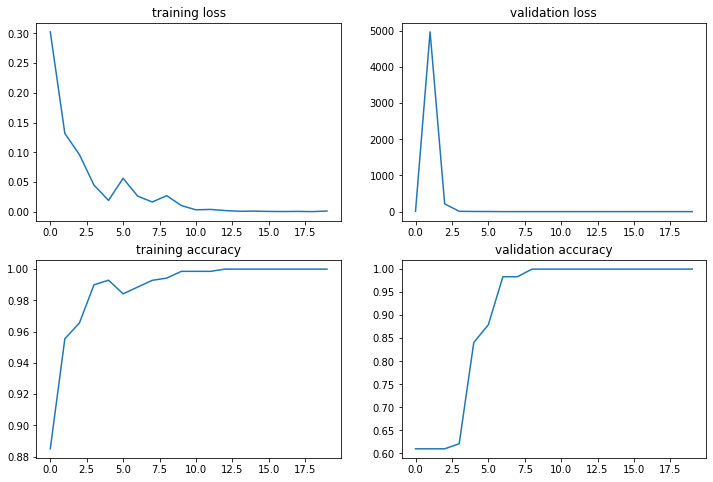

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.title('training loss')
plt.subplot(2,2,2)
plt.plot(history.history['val_loss'])
plt.title('validation loss')
plt.subplot(2,2,3)
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.show()

13/13 [==============================] - 3s 128ms/step


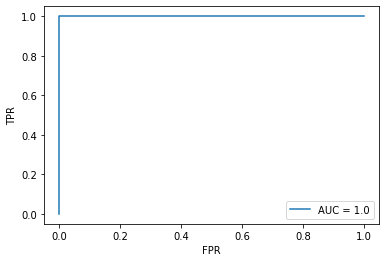

In [ ]:
model.load_weights('model_pretrained_augmented_scheduled.h5') # load the best model
Y_test_pred = model.predict(X_test).reshape(-1)
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, Y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## 5.Visualizing CAM

หลังจากที่เราได้ model ที่พึงพอใจมาแล้ว ต่อจากนี้เราจะให้ model แสดงว่ามันสนใจไปที่จุดใดเมื่อมันทำนายสิ่งนั้นโดย วิธีที่ใช้ในตัวอย่างนี้คือ GradCAM ทั้งนี้การที่จะใช้วิธีนี้ได้จะต้องทำการปรับให้ model สามารถคืนค่า feature map ได้ด้วยซึ่งการปรับ model ให้คืนค่าหลาย output สามารถทำได้ตาม function `get_classification_model_raw`

In [ ]:
def get_classification_model_raw(input_shape = (256, 256, 3)):
    from tensorflow.keras.applications.resnet50 import ResNet50
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top = False)
    pooler = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
    out = tf.keras.layers.Dense(1)(pooler)
    outputs = tf.keras.layers.Activation('sigmoid')(out)
    model = tf.keras.models.Model(inputs = backbone.input, outputs =  [backbone.output, outputs])
    return model

In [ ]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=0):
  '''
  GradCAM heatmap generation 
  Source code is from https://keras.io/examples/vision/grad_cam/
  '''
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
model = get_classification_model_raw(input_shape = (224, 224, 3))
model.load_weights('model_pretrained_augmented.h5')

จะเห็นได้ว่า model ให้ความสนใจบนส่วนของภาพที่มีตำหนิอยู่อย่างชัดเจน

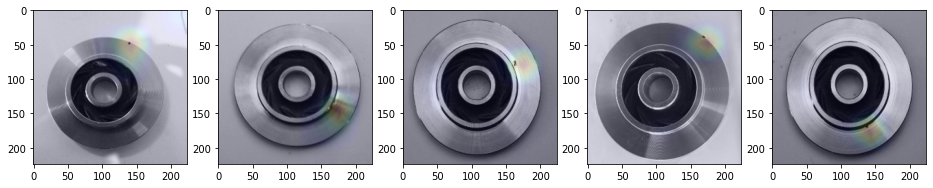

In [ ]:
plt.figure(figsize = (16, 9))
for idx, test_id in enumerate([58, 104, 68, 166, 305]): 
  plt.subplot(1, 5 ,idx+1)
  heatmap = make_gradcam_heatmap(X_test[test_id][np.newaxis, :], model)
  heatmap = cv2.resize(np.uint8(255 * heatmap), (224, 224))

  # print(heatmap)
  plt.imshow( np.array(X_test[test_id], dtype = np.uint8))
  plt.imshow(heatmap,  alpha = 0.1, cmap = 'jet')
plt.show()

# 6. Extracting latent embedding for UMAP/t-SNE visualization

ต่อมาใน section นี้จะตัวอย่างการ visualize embedding ของ model เพื่อประใช้ในการวิเคราะห์พฤติกรรมของ model ทั้งนี้ ในตัวอย่างนี้ได้ใช้ layer สุดท้ายหลังผ่านการทำ global average pooling มาเป็น embedding ตามที่เขียนไว้ใน function `get_classification_model_w_latent`

In [ ]:
def get_classification_model(input_shape = (256, 256, 3)):
    from tensorflow.keras.applications.resnet50 import ResNet50
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top = False)
    pooler = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
    out = tf.keras.layers.Dense(1)(pooler)
    outputs = tf.keras.layers.Activation('sigmoid')(out)
    model = tf.keras.models.Model(inputs = backbone.input, outputs = outputs)
    return model

def get_classification_model_w_latent(input_shape = (256, 256, 3)):
    from tensorflow.keras.applications.resnet50 import ResNet50
    backbone = ResNet50(input_shape = input_shape, weights='imagenet', include_top = False)
    pooler = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
    out = tf.keras.layers.Dense(1)(pooler)
    outputs = tf.keras.layers.Activation('sigmoid')(out)
    model = tf.keras.models.Model(inputs = backbone.input, outputs =  [pooler, outputs])
    return model

ทั้งนี้เราจะเริ่มทดสอบจาก model ที่ pretrain มาจาก Imagenet โดยที่ไม่ได้ผ่านการ train ใดๆเลย

In [ ]:
model = get_classification_model_w_latent(input_shape = (224, 224, 3))

Y_test_pred = model.predict(X_test)
Y_test_pred_embeding = Y_test_pred[0]
print("test embedding shape :", Y_test_pred_embeding.shape)

13/13 [==============================] - 2s 85ms/step
test embedding shape : (390, 2048)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


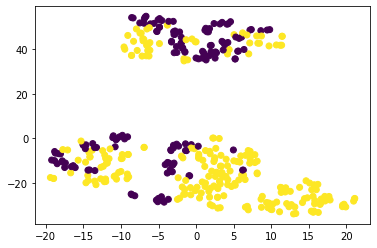

In [ ]:
from sklearn.manifold import TSNE
Y_test_pred_tsne_embeding = TSNE(n_components=2).fit_transform(Y_test_pred_embeding)
plt.scatter(Y_test_pred_tsne_embeding[:, 0], Y_test_pred_tsne_embeding[:, 1], c = Y_test)

จะเห็นได้ว่า แม้ว่าจะไม่ผ่านการ train ใดๆ model ก็สามารถแบ่งวัตถุเป็น 2 กลุ่มคร่าวๆ ได้โดยทั้งสองกลุ่มนั้นมีความต่างของพื้นหลังภาพและการจัดวางวัตถุอย่างชัดเจน

top example


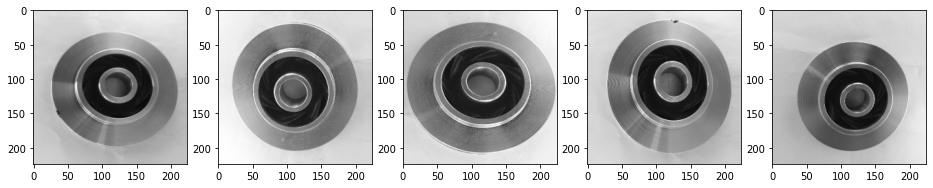

In [ ]:
plt.figure(figsize = (16, 9))
top_example = np.where((Y_test_pred_tsne_embeding[:, 1] > 10) )[0]
top_example = np.random.choice(top_example, 5, replace = False)
print('top example')
for idx, i in enumerate(top_example):
  plt.subplot(1, 5, idx + 1)
  plt.imshow( np.array(X_test[i], dtype = np.uint8) )
plt.show()

bottom example


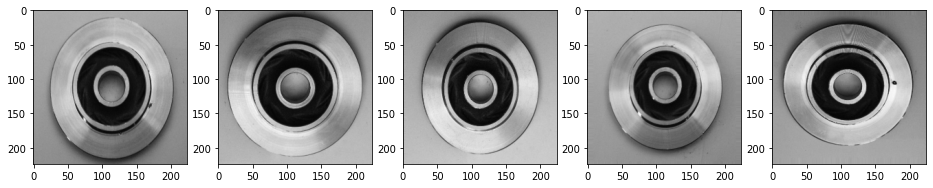

In [ ]:
plt.figure(figsize = (16, 9))
bottom_example = np.where( (Y_test_pred_tsne_embeding[:, 1] <= -10))[0]
bottom_example = np.random.choice(bottom_example, 5, replace = False)

print('bottom example')
for idx, i in enumerate(bottom_example):
  plt.subplot(1, 5, idx + 1)
  plt.imshow( np.array(X_test[i], dtype = np.uint8) )
plt.show()

In [ ]:
model.load_weights('model_pretrained_augmented_scheduled.h5')

Y_test_pred = model.predict(X_test)
Y_test_pred_embeding = Y_test_pred[0]
print("test embedding shape :", Y_test_pred_embeding.shape)

13/13 [==============================] - 1s 83ms/step
test embedding shape : (390, 2048)


เมื่อ load weight ของ model ที่ถูก train เข้าไปจะพบว่า model สามารถแบ่ง data ออกเป็นสองกลุ่มได้อย่างสมบูรณ์

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


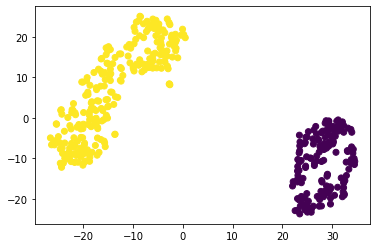

In [ ]:
from sklearn.manifold import TSNE
Y_test_pred_tsne_embeding = TSNE(n_components=2).fit_transform(Y_test_pred_embeding)
plt.scatter(Y_test_pred_tsne_embeding[:, 0], Y_test_pred_tsne_embeding[:, 1], c = Y_test)